In [1]:
# set cell display width
from IPython.display import display, HTML
display(HTML('<style>.container { width: 930px !important; }</style>'))

In [536]:
# import ML tools
import pandas as pd
import numpy as np
import datetime
from pandas.api.types import CategoricalDtype
import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, roc_curve)

In [543]:
# import plotting tools
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from IPython.core.pylabtools import figsize
from IPython.display import display_html
# set grid size and style
figsize(12, 4)
sns.set_style('whitegrid')

Use "mp.colors(<index>)" as color attribute for Seaborn plots.
This is your color palette...


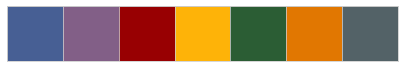

In [4]:
# import custom palette
from custom_modules import my_palette as mp

> **PART 1: EXPLORATORY DATA ANALYSIS**

In [5]:
# read in first dataset
logins_df = pd.read_json('logins.json')

In [6]:
# observe dimensionality of dataset
logins_df.shape

(93142, 1)

This dataset has many observations of one feature.

In [7]:
# observe feature name, data type, and possible null values
logins_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   login_time  93142 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


We have a bunch of Datetime objects.

In [8]:
# observe timestamp range
logins_df['login_time'].describe()

count                   93142
unique                  92265
top       1970-02-12 11:16:53
freq                        3
first     1970-01-01 20:12:16
last      1970-04-13 18:57:38
Name: login_time, dtype: object

The data covers about three and a half months.

In [9]:
# observe some data
logins_df.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


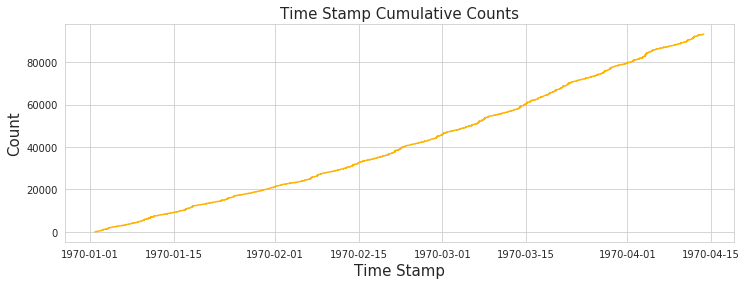

In [10]:
# plot timestamp cumulative distribution

sns.lineplot(
    x=logins_df['login_time'], 
    y=np.linspace(0, len(logins_df['login_time']), 
                  num=len(logins_df['login_time'])), color=mp.colors(3))

plt.xlabel('Time Stamp', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.title('Time Stamp Cumulative Counts', fontsize=15);

The frequency of timestamps appears constant throughout the entire window.<br>
There is no indication of seasonality.

In [11]:
# round timestamps to 15 minute intervals
logins_df['login_time'] = logins_df['login_time'].dt.round('15min') 
logins_df.head()

,login_time
0,1970-01-01 20:15:00
1,1970-01-01 20:15:00
2,1970-01-01 20:15:00
3,1970-01-01 20:15:00
4,1970-01-01 20:30:00


In [12]:
# create day of the week feature
logins_df['day'] = logins_df['login_time'].apply(pd.Timestamp.day_name)
logins_df.head()

,login_time,day
0,1970-01-01 20:15:00,Thursday
1,1970-01-01 20:15:00,Thursday
2,1970-01-01 20:15:00,Thursday
3,1970-01-01 20:15:00,Thursday
4,1970-01-01 20:30:00,Thursday


In [13]:
# count timestamps grouped by day of the week
days_df = logins_df.groupby(['day'], as_index=False).count()
days_df

,day,login_time
0,Friday,15172
1,Monday,8836
2,Saturday,19415
3,Sunday,18204
4,Thursday,11963
5,Tuesday,9251
6,Wednesday,10301


In [14]:
# create ordered categories list for sorting days of the week
days_lst = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
cat_type = CategoricalDtype(categories=days_lst, ordered=True)

In [15]:
# convert day of the week values to ordered categories
days_df['day'] = days_df['day'].astype(cat_type)

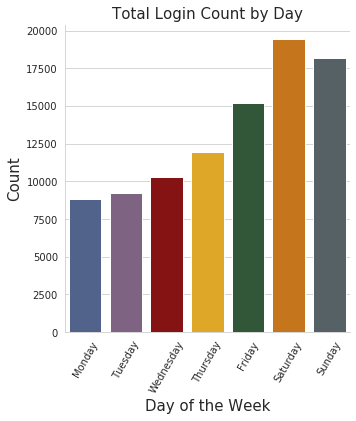

In [16]:
# plot login counts by day

sns.catplot(x='day', y='login_time', data=days_df, kind='bar')

plt.xticks(rotation=60)

plt.xlabel('Day of the Week', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.title('Total Login Count by Day', fontsize=15);

User logins steadily increase throughout the week, peaking on Saturday.

In [17]:
# get day of week DataFrame
dow_df = logins_df.set_index(
    [logins_df.groupby(
        'day')['day'].cumcount(), 'day'])['login_time'].unstack().rename_axis(columns=None)
dow_df.head(3)

,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
0,1970-01-02,1970-01-05,1970-01-03,1970-01-04,1970-01-01 20:15:00,1970-01-06,1970-01-07
1,1970-01-02,1970-01-05,1970-01-03,1970-01-04,1970-01-01 20:15:00,1970-01-06,1970-01-07
2,1970-01-02,1970-01-05,1970-01-03,1970-01-04,1970-01-01 20:15:00,1970-01-06,1970-01-07


In [18]:
# get time of day DataFrame
tod_df = pd.DataFrame([dow_df[a].dt.time for a in dow_df], dow_df.columns).transpose()
tod_df

,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
0,00:00:00,00:00:00,00:00:00,00:00:00,20:15:00,00:00:00,00:00:00
1,00:00:00,00:00:00,00:00:00,00:00:00,20:15:00,00:00:00,00:00:00
2,00:00:00,00:00:00,00:00:00,00:00:00,20:15:00,00:00:00,00:00:00
3,00:00:00,00:15:00,00:00:00,00:00:00,20:15:00,00:15:00,00:00:00
4,00:00:00,00:00:00,00:00:00,00:00:00,20:30:00,00:15:00,00:00:00
...,...,...,...,...,...,...,...
19410,NaT,NaT,23:45:00,NaT,NaT,NaT,NaT
19411,NaT,NaT,23:45:00,NaT,NaT,NaT,NaT
19412,NaT,NaT,23:45:00,NaT,NaT,NaT,NaT
19413,NaT,NaT,23:45:00,NaT,NaT,NaT,NaT


In [19]:
# observe frequencies and most common times of day
tod_df.describe()

,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
count,15172,8836,19415,18204,11963,9251,10301
unique,96,96,96,96,96,96,96
top,22:30:00,11:30:00,04:45:00,04:45:00,11:30:00,11:45:00,11:45:00
freq,419,252,513,601,286,273,308


In [20]:
# get counts for time of day by days of week
tod_counts_df = tod_df.apply(lambda x: x.value_counts()).reindex(columns=days_lst)
tod_counts_df.head()

,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
00:00:00,158,138,173,232,234,304,258
00:15:00,111,163,157,218,253,319,261
00:30:00,144,148,185,199,250,310,267
00:45:00,139,152,155,187,245,311,314
01:00:00,109,141,205,216,231,334,273


In [21]:
def plot_hours_of_day(data):
    """Plots hourly distribution of logins by day of the week"""
    plt.subplots(1, figsize=(16, 10))
    # set color palate cycle
    day_color = 0
    for day in data.columns:
        sns.lineplot(x=np.linspace(0, len(data[day]), num=len(data[day])), 
                     y=data[day], 
                     label=day, color=mp.colors(day_color))
        # get next color
        day_color += 1
    # make fancy time tick labels
    xtick_vals = np.arange(0, len(data.index) + 1, 4)
    xtick_names = np.asarray([datetime.time(i).strftime('%I %p') for i in range(24)])
    plt.xticks(xtick_vals, xtick_names, rotation=60)
    
    plt.xlabel('Time of Day', fontsize=20)
    plt.ylabel('Count', fontsize=20)
    
    # spruce up legend
    leg = plt.legend(ncol=3, fontsize='x-large', markerscale=10)
    for legend in range(len(data.columns)):
        leg.get_lines()[legend].set_linewidth(6)
        
    plt.title('Days of Week Frequencies by Time of Day', fontsize=20);

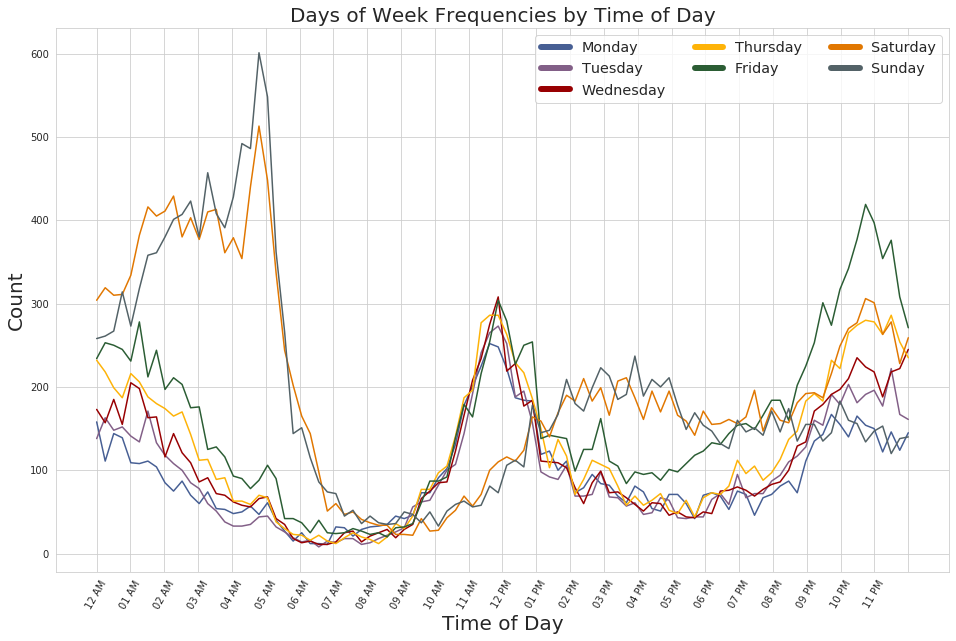

In [22]:
# plot login time of day by occurances for each day of week
plot_hours_of_day(tod_counts_df)

The days of the week show clear distinctions with respect to the variables plotted.

* Midnight-7AM:
    - weekday logins steadily decline (work week)
    - relative frequencies of usage during the weekdays increase as the week progresses
    - weekend calls rise until 5AM, then fall sharply (nightlife)
* 7AM-9AM:<br>
    - lowest time of usage for all days
    - weekend logins are a bit higher than they are for weekdays (walk of shame)
* 9AM-Noon:
    - calls increase for all days
    - weekday usage increases more sharply than weekend usage (9-5ers)
* Noon-5PM:<br>
    - weekday logins decline steadily
    - weekend usage increases until 2PM, then holds steady (brunch)
* 5PM-8PM:<br>
    - calls on all days hold steady, except Friday, which rise (TGIF)
    - Friday-Sunday usage is greater than for other days
* 8PM-10PM:<br>
    - logins on all days increase
* 10PM-Midnight:<br>
    - overall, usage declines for every day
    - Wednesday-Sunday logins increase until just before 11PM, then start to decline
    - Friday calls are the most frequent (weekend warrior)
    - Thursday and Sunday logins are the next strongest (Friday eve)

> **PART 2: EXPERIMENT & METRICS DESIGN**

COMING SOON

> **PART 3: PREDICTIVE MODELING**

In [363]:
# read in second dataset
df = pd.read_json('ultimate_data_challenge.json')

In [86]:
# observe dimensionality of dataset
df.shape

(50000, 12)

In [87]:
# observe feature names, data types, and possible null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [91]:
# observe feature ranges
df.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
count,50000.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000,49799.000000
mean,2.278200,4.601559,1.074764,8.849536,60.926084,5.796827,4.778158
std,3.792684,0.617338,0.222336,19.958811,37.081503,5.707357,0.446652
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,4.300000,1.000000,0.000000,33.300000,2.420000,4.700000
50%,1.000000,4.900000,1.000000,0.000000,66.700000,3.880000,5.000000
75%,3.000000,5.000000,1.050000,8.600000,100.000000,6.940000,5.000000
max,125.000000,5.000000,8.000000,100.000000,100.000000,160.960000,5.000000


There's one user who took 125 trips in the first 30 days, over 4 times a day.<br>
This is most likely a data error.

In [288]:
# observe any extreme values
df['trips_in_first_30_days'].sort_values(ascending=False)[:5]

18514    125
99        73
3030      71
29070     63
48804     58
Name: trips_in_first_30_days, dtype: int64

The other high values seem plausible.<br>
I will remove that observation.

In [364]:
# drop outlier
df.drop(
    df[df['trips_in_first_30_days'] == df['trips_in_first_30_days'].max()].index, 
    inplace=True)
df['trips_in_first_30_days'].max()

73

In [291]:
# observe other extreme values
df['avg_dist'].sort_values(ascending=False)[:5]

20701    160.96
534      129.89
1302      79.69
22290     79.34
47595     77.13
Name: avg_dist, dtype: float64

Although there are two observations that are extreme, it is likely that these data points are reliable.

In [92]:
# observe some data
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [93]:
# get counts for categorical variables
print(df['city'].value_counts(), df['phone'].value_counts(), sep='\n\n')

Winterfell        23336
Astapor           16534
King's Landing    10130
Name: city, dtype: int64

iPhone     34582
Android    15022
Name: phone, dtype: int64


In [126]:
# check data types
print(type(df['signup_date'][0]), type(df['last_trip_date'][0]), sep='\n\n')

<class 'pandas._libs.tslibs.timestamps.Timestamp'>

<class 'pandas._libs.tslibs.timestamps.Timestamp'>


In [365]:
# convert time strings to useful  objects
df['signup_date'] = df['signup_date'].apply(pd.Timestamp)
df['last_trip_date'] = df['last_trip_date'].apply(pd.Timestamp)

In [127]:
# trust but verify
print(type(df['signup_date'][0]), type(df['last_trip_date'][0]), sep='\n\n')

<class 'pandas._libs.tslibs.timestamps.Timestamp'>

<class 'pandas._libs.tslibs.timestamps.Timestamp'>


In [94]:
# observe feature ranges
df['signup_date'].describe()

count                   50000
unique                     31
top       2014-01-18 00:00:00
freq                     2948
first     2014-01-01 00:00:00
last      2014-01-31 00:00:00
Name: signup_date, dtype: object

In [95]:
# observe feature ranges
df['last_trip_date'].describe()

count                   50000
unique                    182
top       2014-06-29 00:00:00
freq                     2036
first     2014-01-01 00:00:00
last      2014-07-01 00:00:00
Name: last_trip_date, dtype: object

In [99]:
# observe one user
df.loc[0]

city                           King's Landing
trips_in_first_30_days                      4
signup_date               2014-01-25 00:00:00
avg_rating_of_driver                      4.7
avg_surge                                 1.1
last_trip_date            2014-06-17 00:00:00
phone                                  iPhone
surge_pct                                15.4
ultimate_black_user                      True
weekday_pct                              46.2
avg_dist                                 3.67
avg_rating_by_driver                        5
Name: 0, dtype: object

In [125]:
# check time data integrity
np.sum(df['last_trip_date'] - df['signup_date'] < pd.Timedelta('0 days'))

0

In [366]:
# get hypothetical current date
today = df['last_trip_date'].max()
today

Timestamp('2014-07-01 00:00:00')

In [367]:
# get 30 day Timedelta
delta_30 = pd.Timedelta('30 days')
delta_30

Timedelta('30 days 00:00:00')

In [111]:
def set_retained_value(row, val):
    """Assigns retained value based on boolean time condition"""
    return val[row]

In [368]:
# set boolean value assignments
retained_dict = {True: 1, False: 0}

In [369]:
# create binary retained user feature
df['retained'] = (today - df['last_trip_date'] <= delta_30).apply(
    set_retained_value, args=(retained_dict, ))
df[['last_trip_date', 'retained']].head()

,last_trip_date,retained
0,2014-06-17,1
1,2014-05-05,0
2,2014-01-07,0
3,2014-06-29,1
4,2014-03-15,0


In [370]:
# get retention rate for January signups
np.round(df['retained'].mean() * 100)

38.0

The data is slightly imbalanced.

A little over a third of the people who signed up were retained.

In [567]:
def plot_correlations(data):
    """Return heatmap plot of correlations"""
    fig, ax = plt.subplots(figsize=(6.5,6.5))

    sns.set(font_scale=0.8)
    sns.heatmap(
        data.corr(), vmin=0, vmax=1.0, center=0, fmt='0.2f', square=True, 
        linewidths=0.5, annot=True, cbar_kws={"shrink": 0.60});

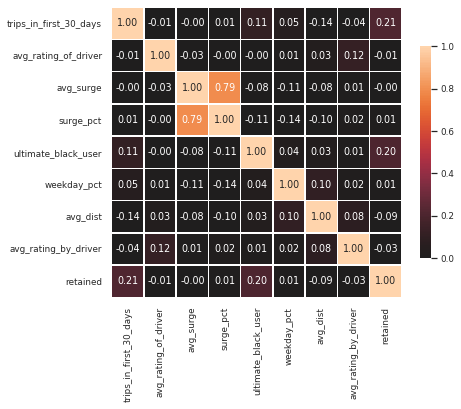

In [568]:
# plot correlations in dataset
plot_correlations(df)

The obligatory correlation plot offers little insight.

In [496]:
def plot_categoricals(data):
    """Plots target variable grouped by each categorical feature"""
    # establish figure height
    num_subplots = len(data.columns) - 1
    fig_height = num_subplots * 4
    fig, axes = plt.subplots(nrows=num_subplots, figsize=(12, fig_height))
    # plot features in dataset
    count = 1
    for col in data.drop('retained', axis=1):
        plt.subplot(num_subplots, 1, count)
        plt.ylim(0, 0.7)
        # gather retained data by feature
        feature_df = data.groupby(col)['retained'].mean().reset_index()
        # mix up the color palette
        palette = [mp.colors(count - 1), mp.colors(count + 3), mp.colors(count + 2)]
        # plot feature values vs. retention rate
        sns.barplot(x=col, y='retained', data=feature_df, palette=palette)
        # get count of unique values in category
        num_cats = len(data[col].dropna().unique())
        # plot average retention rates
        plt.hlines(df['retained'].mean(), xmin=-0.5, xmax=num_cats - 0.5, 
                   linestyles=(0, (3, 1, 1, 1)), 
                   label='Average Overall Retention Rate', colors='k')
        plt.hlines(feature_df['retained'].mean(), xmin=-0.5, xmax=num_cats - 0.5, 
                   linestyles=(0, (3, 1, 1, 1, 1, 1)), 
                   label='Average Categorical Retention Rate', colors='r')
        count += 1
        plt.xlabel(col, fontsize=15)
        plt.ylabel('Retention Rate', fontsize=15)
        plt.legend(loc=2, fontsize='large')
    plt.suptitle("Retention Rate for Catergorical Variables", y=1.04, fontsize=20)
    plt.tight_layout();

In [371]:
# pick out categorical variables
cat_cols_lst = [feature for feature in df.columns if (
    type(df[feature][0]) is str) | (
    type(df[feature][0]) is np.bool_)]
cat_cols_lst

['city', 'phone', 'ultimate_black_user']

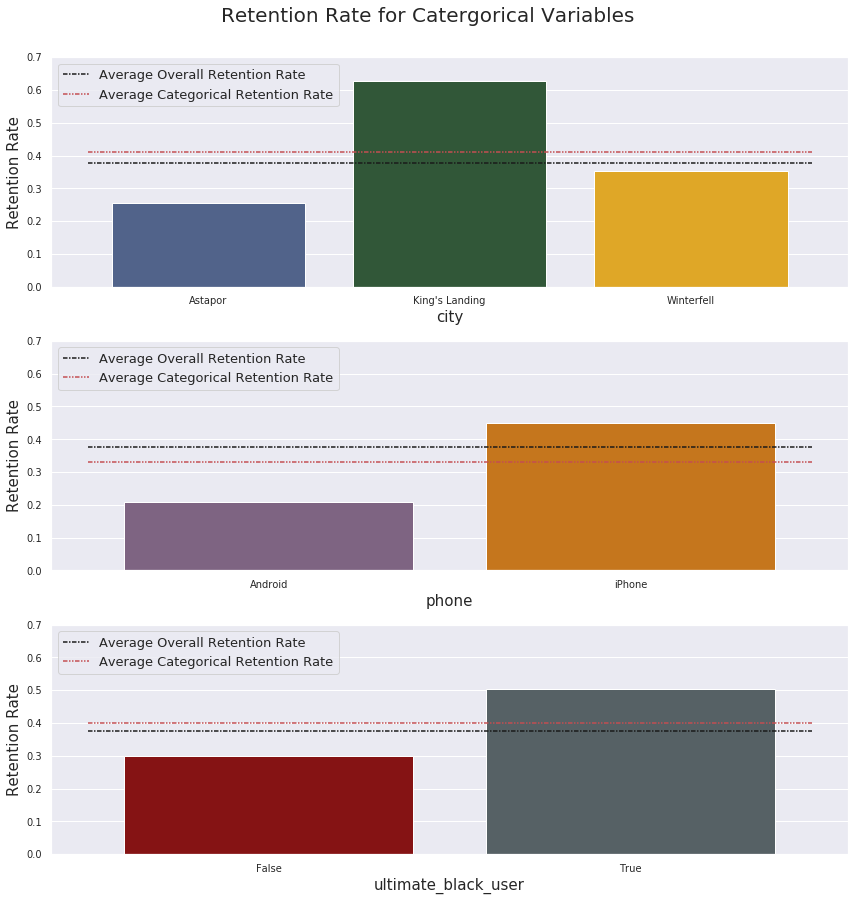

In [497]:
# plot categorical variables vs target
plot_categoricals(df[cat_cols_lst + ['retained']])

King's Landing inhabitants, iPhone users, and Ultimate Black Users have the highest retention rates in their categories.

In [526]:
# separate data into features and target
X = df.drop('retained', axis=1)
y = df['retained']

In [527]:
# check data type before encoding
type(X['ultimate_black_user'][0])

numpy.bool_

In [528]:
# convert data type
X['ultimate_black_user'] = X['ultimate_black_user'].astype(str)
type(X['ultimate_black_user'][0])

str

In [529]:
# encode categorical variables
X = pd.get_dummies(X, prefix=cat_cols_lst).rename(str.lower, axis=1)
X.head()

,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver,city_astapor,city_king's landing,city_winterfell,phone_android,phone_iphone,ultimate_black_user_false,ultimate_black_user_true
0,4,2014-01-25,4.7,1.10,2014-06-17,15.4,46.2,3.67,5.0,0,1,0,0,1,0,1
1,0,2014-01-29,5.0,1.00,2014-05-05,0.0,50.0,8.26,5.0,1,0,0,1,0,1,0
2,3,2014-01-06,4.3,1.00,2014-01-07,0.0,100.0,0.77,5.0,1,0,0,0,1,1,0
3,9,2014-01-10,4.6,1.14,2014-06-29,20.0,80.0,2.36,4.9,0,1,0,0,1,0,1
4,14,2014-01-27,4.4,1.19,2014-03-15,11.8,82.4,3.13,4.9,0,0,1,1,0,1,0


Concerning the Timestamp columns, I'm going to drop them.<br>
The signup date is a fairly random number between 1 and 31.<br>
There may be some prediction value gained by convering it to days of the week, but I'm deciding to proceed without it.<br>
The last trip date has already been used to determine the retained status.<br>
Keeping this feature may open the model up to a data leak and cause overfitting.

In [530]:
# drop Timestamp objects
X.drop(['signup_date', 'last_trip_date'], axis=1, inplace=True)
X.head()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver,city_astapor,city_king's landing,city_winterfell,phone_android,phone_iphone,ultimate_black_user_false,ultimate_black_user_true
0,4,4.7,1.10,15.4,46.2,3.67,5.0,0,1,0,0,1,0,1
1,0,5.0,1.00,0.0,50.0,8.26,5.0,1,0,0,1,0,1,0
2,3,4.3,1.00,0.0,100.0,0.77,5.0,1,0,0,0,1,1,0
3,9,4.6,1.14,20.0,80.0,2.36,4.9,0,1,0,0,1,0,1
4,14,4.4,1.19,11.8,82.4,3.13,4.9,0,0,1,1,0,1,0


In [531]:
# split dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=27)

In [305]:
def get_base_model(features, target):
    """Return base XGBoost regressor model"""
    model = xgb.XGBClassifier(objective='binary:logistic', random_state=27, n_jobs=-1)
    model.fit(features, target)
    
    return model

In [349]:
def get_params(model):
    """Return hyperparameters of interest from regressor"""
    series = pd.Series(
        model.get_params(), name='model_params').drop(
        ['base_score', 'booster', 'missing', 'n_jobs', 'nthread', 'objective', 
         'random_state', 'scale_pos_weight', 'seed', 'silent', 'verbosity'])
    
    return series

In [532]:
# instantiate base model for given target and get parameters
base_model = get_base_model(X_train, y_train)
get_params(base_model)

colsample_bylevel      1
colsample_bynode       1
colsample_bytree       1
gamma                  0
learning_rate        0.1
max_delta_step         0
max_depth              3
min_child_weight       1
n_estimators         100
reg_alpha              0
reg_lambda             1
subsample              1
Name: model_params, dtype: object

In [355]:
def get_cv_adj_r2(features, target, model):
    """Return cross-validation average adjusted R2 score and adjusted R2 score range"""
    cv_results = cross_val_score(model, features, target, cv=10, n_jobs=-1)
    
    n = features.shape[0]
    p = features.shape[1]
    adj_r2 = 1 - (1 - cv_results) * ((n - 1)  / (n - p - 1))

    # get range of scores
    results_range = (np.min(adj_r2), np.max(adj_r2))
    # get average score and round to 5 decimal places
    ave_result = np.mean(adj_r2)

    return f'Average Adjusted R2 Score: {ave_result:.4f}, Range: ({results_range[0]:.4f}, {results_range[1]:.4f})'

In [533]:
# get statistics for 10 fold cross-validation
get_cv_adj_r2(X_train, y_train, base_model)

'Average Adjusted R2 Score: 0.7863, Range: (0.7759, 0.7982)'

The base model is a fairly strong predictor with a narrow range of cross-validation scores.

In [418]:
def plot_predictions(features, target, model):
    """Return plot of distribution of residuals"""
    X_train, X_test, y_train, y_test = train_test_split(
        features, target, test_size=0.2, random_state=27)
    guesses = []
    for guess, truth in zip(model.predict(X_test), y_test):
        if guess == truth:
            guesses.append('Good Guess')
        else:
            guesses.append('Bad Guess')
    sns.countplot(guesses)

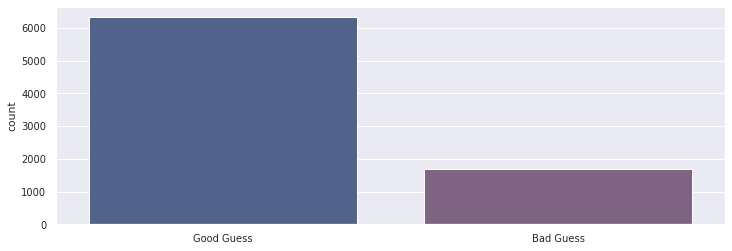

In [534]:
# plot prediction for out of the box binary classifier model
plot_predictions(X_train, y_train, base_model)

We have a fairly good guessing machine.

In [544]:
def get_reports(features, target, model):
    """Return classification reports and confusion matrices for traning and test data"""
    X_train, X_test, y_train, y_test = train_test_split(
        features, target, test_size=0.2, random_state=27)    
    # get classification reports
    cr_train_df = pd.DataFrame(
        classification_report(
            y_train, model.predict(X_train), digits=3, output_dict=True)).transpose()
    cr_test_df = pd.DataFrame(
        classification_report(
            y_test, model.predict(X_test), digits=3, output_dict=True)).transpose()
    # get confusion matrices
    cm_train_df = pd.DataFrame(
        confusion_matrix(y_train, model.predict(X_train)))
    cm_test_df = pd.DataFrame(
        confusion_matrix(y_test, model.predict(X_test)))
    # prep data for HTML display
    df1_styler = cr_train_df.style.set_table_attributes(
        "style='display:inline'").set_caption(
        'Training Classification Report')
    df2_styler = cr_test_df.style.set_table_attributes(
        "style='display:inline'").set_caption(
        'Test Classification Report')
    df3_styler = cm_train_df.style.set_table_attributes(
        "style='display:inline'").set_caption(
        'Training Confusion Matrix')
    df4_styler = cm_test_df.style.set_table_attributes(
        "style='display:inline'").set_caption(
        'Test Confusion Matrix')
    # display reports and matrices
    display_html(
        df1_styler._repr_html_() 
        + df2_styler._repr_html_() 
        + df3_styler._repr_html_() 
        + df4_styler._repr_html_(), raw=True)    

In [545]:
# observe classification metrics
get_reports(X_train, y_train, base_model)

,precision,recall,f1-score,support
0,0.811685,0.860886,0.835562,19962.000000
1,0.743512,0.668771,0.704164,12037.000000
accuracy,0.788618,0.788618,0.788618,0.788618
macro avg,0.777598,0.764828,0.769863,31999.000000
weighted avg,0.786040,0.788618,0.786134,31999.000000
,precision,recall,f1-score,support
0,0.813049,0.865300,0.838361,5026.000000
1,0.744625,0.663753,0.701867,2974.000000
accuracy,0.790375,0.790375,0.790375,0.790375
macro avg,0.778837,0.764526,0.770114,8000.000000


In [541]:
def plot_roc_curve(features, target, model):
    """Return ROC curve"""
    X_train, X_test, y_train, y_test = train_test_split(
        features, target, test_size=0.2, random_state=27) 
    # get ROC data for training data
    fpr_train, tpr_train = roc_curve(y_train, model.predict(X_train))[:2]
    roc_score_train = roc_auc_score(y_train, model.predict(X_train))
    # get ROC data for test data
    fpr_test, tpr_test = roc_curve(y_test, model.predict(X_test))[:2]
    roc_score_test = roc_auc_score(y_test, model.predict(X_test))
    
    ax = sns.lineplot(fpr_train, tpr_train, color=mp.colors(4), label='Training Model')
    ax = sns.lineplot(fpr_test, tpr_test, color=mp.colors(5), label='Test Model')

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

    plt.legend()
    plt.title('ROC Curves');
    return f'Training ROC AUC Score: {roc_score_train:.4f}, Test ROC AUC Score: {roc_score_test:.4f}'

'Training ROC AUC Score: 0.7648, Test ROC AUC Score: 0.7645'

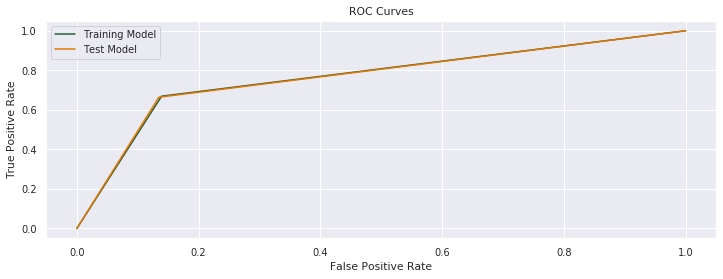

In [542]:
# observe ROC AUC scores and ROC curves for both training and test data
plot_roc_curve(X_train, y_train, base_model)

The model performs the same on the test data as it does on the training data.

In [560]:
def plot_feature_importance(model):
    """Plots the features by importance to model"""
    sns.set_style('dark')
    
    ax = xgb.plot_importance(base_model)
    
    ax.figure.set_size_inches(12, 8)
    
    plt.xlabel('F-score', fontsize=15)
    plt.ylabel('Features', fontsize=18)
    plt.title('Feature Importance', fontsize=20);

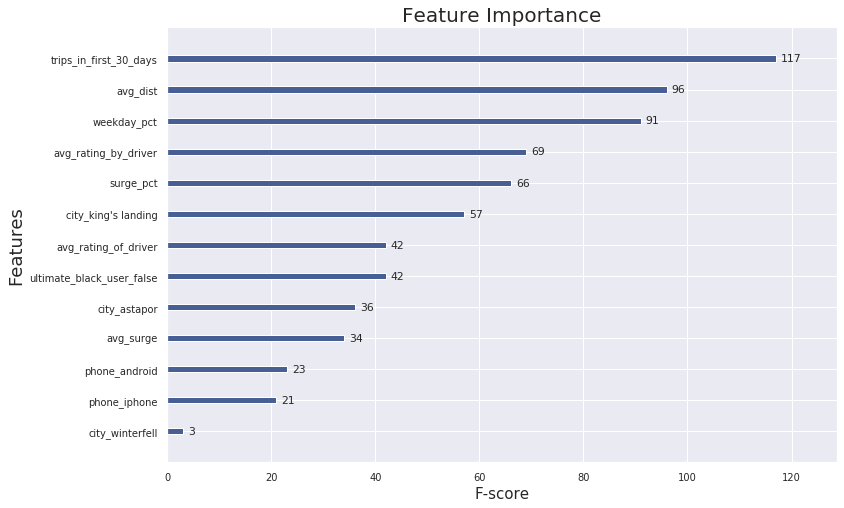

In [561]:
# observe feature performance
plot_feature_importance(base_model)

I'll look at some of the dominant features for the predictions.

TO BE CONTINUED...

In [ ]:
sns.barplot(x='trips_in_first_30_days', y='retained', 
            data=df.groupby('trips_in_first_30_days')['retained'].mean().reset_index());